In [1]:
###############################################################################
### python imports                                                          ###
###############################################################################

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

# from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

import acquire as acq
import prepare as prep
import clusterfunctions as cf

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from dfo import DFO, set_dfo
from prepare import convert_to_dates, get_column_values_stats, retype_cols, remove_cols, nulls_by_row

In [3]:
local_settings.splain=True
local_settings.debug=True
splain = local_settings.splain
debug = local_settings.debug

In [4]:
from wrangle_zillow import get_zillow_data, get_zillow_local_data, prep_zillow_data, sqls, keep_cols

#### Acquire & Summarize¶
##### Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.
Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid .
Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
Only include properties that include a latitude and longitude value.

In [5]:
dfo = set_dfo(get_zillow_local_data(csv='zillow_local_mvp.csv'), splain=True)

2019-11-08 12:13:23 starting get_zillow_local_data
2019-11-08 12:13:23 starting csv_df
2019-11-08 12:13:23 starting check_df
2019-11-08 12:13:23 starting frame_splain
DATAFRAME SHAPE:
(52089, 10) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52089 entries, 0 to 52088
Data columns (total 10 columns):
Unnamed: 0                      52089 non-null int64
parcelid                        52089 non-null int64
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8), int64(2)
memory usage: 4.0 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean

In [6]:
df = dfo.df
df = remove_cols(df, ['Unnamed: 0'])

2019-11-08 12:13:24 starting remove_cols
2019-11-08 12:13:24 ending remove_cols ; time: 0:00:00.006842


In [7]:
dfo.index_columns = 'parcelid'
dfo.y_column = 'logerror'

In [8]:
df = df.set_index(dfo.index_columns)

In [9]:
frame_splain(df, title='Zillow Data', splain=True)

2019-11-08 12:13:24 starting frame_splain
ZILLOW DATA SHAPE:
(52089, 8) 

ZILLOW DATA INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB
None 

ZILLOW DATA DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfinishedsquarefeet  52089.0  1.923432e+03    1003.068834  

In [10]:
date_columns = ['transactiondate']
df = convert_to_dates(df, cols=date_columns)

2019-11-08 12:13:24 starting convert_to_dates
2019-11-08 12:13:24 ending convert_to_dates ; time: 0:00:00.002777


In [11]:
frame_splain(df, splain=True)

2019-11-08 12:13:24 starting frame_splain
DATAFRAME SHAPE:
(52089, 8) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfinishedsquarefeet  52089.0  1.923432e+03    1003.068834   
lati

###### Find string categoricals

In [12]:
df_strings = get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes=='object'],
    max_uniques=20000,
    limit_to_max=True
)
df_strings

2019-11-08 12:13:24 starting get_column_values_stats
2019-11-08 12:13:24 ending get_column_values_stats ; time: 0:00:00.130252


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."


In [13]:
df_strings.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object', name='cols')

In [14]:
string_categoricals = [
    'airconditioningdesc', 
    'architecturalstyledesc', 
    'buildingclassdesc', 
    'county', 
    'state', 
    'heatingorsystemdesc', 
    'propertycountylandusecode', 
    'propertylandusedesc', 
    'propertyzoningdesc', 
    'storydesc', 
    'taxdelinquencyflag', 
    'typeconstructiondesc'
]

In [15]:
df = retype_cols(df, cols=string_categoricals, to_dtype='category')
df.info()

2019-11-08 12:13:24 starting retype_cols
2019-11-08 12:13:24 ending retype_cols ; time: 0:00:00.003028
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


###### Find Numeric Categoricals

In [16]:
df_cat_check = prep.get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes!='category'],
    max_uniques=750000,
    target_col=dfo.y_column,
    limit_to_max=True
)
df_cat_check

2019-11-08 12:13:24 starting get_column_values_stats
2019-11-08 12:13:24 ending get_column_values_stats ; time: 0:00:00.108853


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."
latitude,float64,52089,0,0.0,50293,"[33634931.0, 34449266.0, 33886168.0, 34245180...."
longitude,float64,52089,0,0.0,50571,"[-117869207.0, -119281531.0, -117823170.0, -11..."
structuretaxvaluedollarcnt,float64,52089,0,0.0,37220,"[485713.0, 88000.0, 85289.0, 108918.0, 276684...."
structuredollarpersqft,float64,52089,0,0.0,51809,"[156.6816129032258, 60.068259385665534, 68.615..."


In [17]:
df_cat_check.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'structuretaxvaluedollarcnt', 'structuredollarpersqft'],
      dtype='object', name='cols')

In [18]:
numeric_categoricals = [
    'airconditioningtypeid', 
    'architecturalstyletypeid', 
    'buildingclasstypeid', 
    'buildingqualitytypeid',
    'decktypeid', 
    'fips', 
    'hashottuborspa',
    'heatingorsystemtypeid',
    'pooltypeid10', 
    'pooltypeid2', 
    'pooltypeid7', 
    'propertylandusetypeid',
    'regionidcounty', 
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'rawcensustractandblock',
    'censustractandblock',
    'storytypeid', 
    'threequarterbathnbr', 
    'numberofstories', 
    'fireplaceflag', 
    'assessmentyear', 
    'typeconstructiontypeid', 
    'transactions'
]

In [19]:
df = retype_cols(df, cols=numeric_categoricals, to_dtype='category')
df.info()

2019-11-08 12:13:25 starting retype_cols
2019-11-08 12:13:25 ending retype_cols ; time: 0:00:00.000407
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


In [20]:
dfo.df = df
dfo.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 8 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(8)
memory usage: 3.6 MB


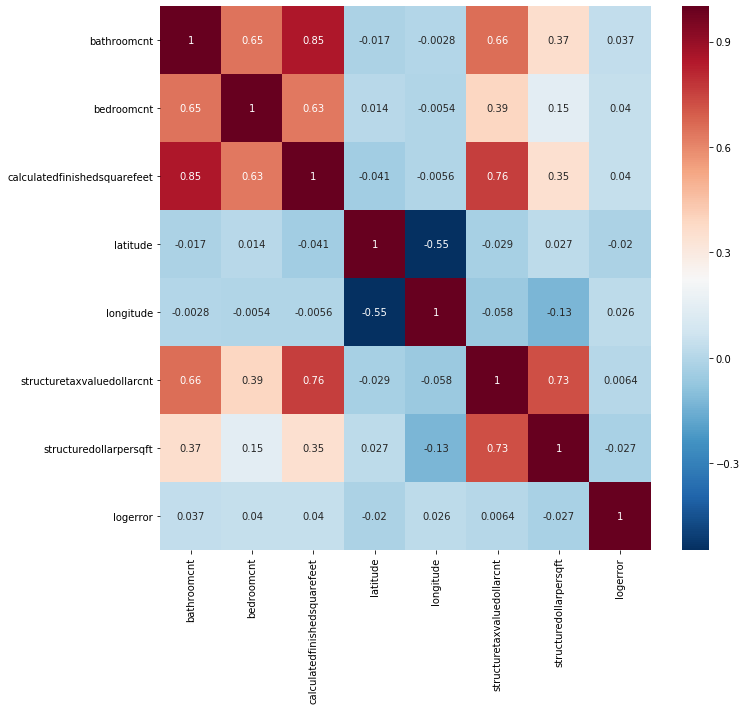

In [21]:
plt.figure(figsize=(11,10))
cor = df.corr()
plot = sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu_r)

In [22]:
df.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,structuretaxvaluedollarcnt,structuredollarpersqft,logerror
bathroomcnt,1.000000,0.647641,0.852965,-0.017218,-0.002820,0.660065,0.365242,0.037370
bedroomcnt,0.647641,1.000000,0.634529,0.013560,-0.005412,0.390788,0.145150,0.039670
calculatedfinishedsquarefeet,0.852965,0.634529,1.000000,-0.040970,-0.005573,0.761486,0.353193,0.040374
latitude,-0.017218,0.013560,-0.040970,1.000000,-0.547254,-0.029218,0.026689,-0.020002
longitude,-0.002820,-0.005412,-0.005573,-0.547254,1.000000,-0.058251,-0.126301,0.025511
structuretaxvaluedollarcnt,0.660065,0.390788,0.761486,-0.029218,-0.058251,1.000000,0.726435,0.006379
structuredollarpersqft,0.365242,0.145150,0.353193,0.026689,-0.126301,0.726435,1.000000,-0.027384
logerror,0.037370,0.039670,0.040374,-0.020002,0.025511,0.006379,-0.027384,1.000000


In [23]:
dfo.X, dfo.y = prep.xy_df(dfo.df, dfo.y_column)

2019-11-08 12:13:28 starting xy_df
2019-11-08 12:13:28 starting frame_splain
2019-11-08 12:13:28 ending frame_splain ; time: 0:00:00.001206
2019-11-08 12:13:28 starting frame_splain
2019-11-08 12:13:28 ending frame_splain ; time: 0:00:00.000294
2019-11-08 12:13:28 ending xy_df ; time: 0:00:00.013079


In [24]:
X = dfo.X

In [25]:
cluster_cols = ['longitude', 'latitude', 'structuredollarpersqft']
cluster_col = ['cluster']
ignore_cols = ['structuretaxvaluedollarcnt']
non_cluster_cols = [col for col in X.columns if col not in cluster_cols + ignore_cols + cluster_col]
non_cluster_cols

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']

In [26]:
Xc = X[cluster_cols]
Xc=pd.DataFrame(Xc)

In [27]:
Xnc = X[non_cluster_cols]
Xnc.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
parcelid,,,
14297519,3.5,4.0,3100.0
17052889,1.0,2.0,1465.0
14186244,2.0,3.0,1243.0
12177905,3.0,4.0,2376.0
12095076,3.0,4.0,2962.0


##### MATT! MERGE y BACK TO Xnc

In [28]:
Xc_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(Xc)
Xc_scaled = pd.DataFrame(Xc_scaler.transform(Xc), columns=Xc.columns.values).set_index([Xc.index.values])
Xc_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 3 columns):
longitude                 52089 non-null float64
latitude                  52089 non-null float64
structuredollarpersqft    52089 non-null float64
dtypes: float64(3)
memory usage: 1.6 MB


In [29]:
Xc_scaled['sdpsf_score'] = Xc_scaled.structuredollarpersqft * 15
Xc_structuredollarpersqft = Xc_scaled[['structuredollarpersqft']]
Xc_scaled = Xc_scaled.drop(columns='structuredollarpersqft')

In [30]:
cf.set_kmeans_clusters(Xc_scaled, n_clusters=8, random_state=12345)
Xc_scaled.head(15)

2019-11-08 12:14:05 starting set_kmeans_clusters
2019-11-08 12:14:07 ending set_kmeans_clusters ; time: 0:00:02.108349


,longitude,latitude,sdpsf_score,cluster
14297519,0.836227,0.199108,1.626961,7
17052889,0.100941,0.750024,0.623486,0
14186244,0.860195,0.369076,0.712261,2
12177905,0.642809,0.611955,0.475713,4
12095076,0.674513,0.544318,0.969803,0
12069064,0.643519,0.547032,0.265441,4
12790562,0.764534,0.419180,0.606327,2
11104527,0.526362,0.740353,1.110677,0
13944538,0.777071,0.291458,0.748477,2
17110996,0.158677,0.607253,0.749794,0


In [31]:
@timeifdebug
def features_2d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-1):
        for y in range(x+1, n):
            line = [cols[x], cols[y]]
            grid.append(line)
    
    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df



In [32]:
@timeifdebug
def features_3d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-2):
        for y in range(x+1, n-1):
            for z in range(y+1, n):
                line = [cols[x], cols[y], cols[z]]
                grid.append(line)
    

    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col', 'z_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df

In [33]:
features_cl = features_2d(Xc_scaled, c_col=cluster_col[0])
features_cl

2019-11-08 12:14:08 starting features_2d
2019-11-08 12:14:08 ending features_2d ; time: 0:00:00.002756


,x_col,y_col,c_col
0,longitude,latitude,cluster
1,longitude,sdpsf_score,cluster
2,latitude,sdpsf_score,cluster


In [34]:
@timeifdebug
def plot_features_2D(feature_df, df, x_col='x_col', y_col='y_col', c_col='c_col'):
    x_vals = feature_df[x_col]
    y_vals = feature_df[y_col]
    c_vals = feature_df[c_col]
    n = len(x_vals)
    for idx in range(0,n):
        plt.figure(figsize=(8,7))
        cf.plot_2d_clusters(
            df, 
            x_col=x_vals[idx], 
            y_col=y_vals[idx], 
            c_col=c_vals[idx], 
            alpha=.02, 
            marker='x', 
            s=250, 
            c='black'
        )
        plt.show()

In [35]:
#plot_features_2D(features_cl, Xc_scaled)

In [36]:
cluster_y = prep.df_join_xy(Xc_scaled[[cluster_col[0]]], dfo.y) 

2019-11-08 12:14:11 starting df_join_xy
2019-11-08 12:14:11 starting frame_splain
2019-11-08 12:14:11 ending frame_splain ; time: 0:00:00.000216
2019-11-08 12:14:11 ending df_join_xy ; time: 0:00:00.015483


In [37]:
frame_splain(cluster_y, splain=True)

2019-11-08 12:14:11 starting frame_splain
DATAFRAME SHAPE:
(52089, 2) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 2 columns):
cluster     52089 non-null int32
logerror    52089 non-null float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None 

DATAFRAME DESCRIPTION:
            count      mean       std      min       25%       50%       75%  \
cluster   52089.0  3.276891  2.409869  0.00000  2.000000  3.000000  6.000000   
logerror  52089.0  0.018249  0.175990 -4.65542 -0.024575  0.006956  0.040526   

               max  
cluster   7.000000  
logerror  5.262999   

DATAFRAME HEAD:
          cluster  logerror
14297519        7  0.025595
17052889        0  0.055619
14186244        2  0.005383
12177905        4 -0.103410
12095076        0 -0.001011 

2019-11-08 12:14:11 ending frame_splain ; time: 0:00:00.046161


In [38]:
#cluster_stats[y_col + '_mean'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].mean())
#cluster_stats[y_col + '_std'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].std())

In [39]:
cluster_stats = cluster_y.groupby('cluster').logerror.agg(['count', 'mean', 'std']).reset_index()

In [40]:
XncC = prep.df_join_xy(Xnc, Xc_scaled['cluster']) 
XncC.head()

2019-11-08 12:14:13 starting df_join_xy
2019-11-08 12:14:13 starting frame_splain
2019-11-08 12:14:13 ending frame_splain ; time: 0:00:00.000548
2019-11-08 12:14:13 ending df_join_xy ; time: 0:00:00.011043


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster
parcelid,,,,
14297519,3.5,4.0,3100.0,7
17052889,1.0,2.0,1465.0,0
14186244,2.0,3.0,1243.0,2
12177905,3.0,4.0,2376.0,4
12095076,3.0,4.0,2962.0,0


#### Modeling begin
Will apply models to the different clusters, based on size 

In [41]:
XncC = prep.df_join_xy(Xnc, Xc_scaled['cluster'])
XncC= prep.df_join_xy(XncC, df['logerror'])
XncC.head()

2019-11-08 12:14:15 starting df_join_xy
2019-11-08 12:14:15 starting frame_splain
2019-11-08 12:14:15 ending frame_splain ; time: 0:00:00.000215
2019-11-08 12:14:15 ending df_join_xy ; time: 0:00:00.010936
2019-11-08 12:14:15 starting df_join_xy
2019-11-08 12:14:15 starting frame_splain
2019-11-08 12:14:15 ending frame_splain ; time: 0:00:00.000304
2019-11-08 12:14:15 ending df_join_xy ; time: 0:00:00.004576


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
parcelid,,,,,
14297519,3.5,4.0,3100.0,7,0.025595
17052889,1.0,2.0,1465.0,0,0.055619
14186244,2.0,3.0,1243.0,2,0.005383
12177905,3.0,4.0,2376.0,4,-0.103410
12095076,3.0,4.0,2962.0,0,-0.001011


In [42]:
cluster_stats

,cluster,count,mean,std
0,0,9654,0.014766,0.159611
1,1,2961,0.013827,0.181966
2,2,13051,0.021607,0.166706
3,3,492,0.008973,0.225218
4,4,11543,0.024813,0.197406
5,5,60,-0.059627,0.350234
6,6,6617,0.008016,0.153261
7,7,7711,0.018774,0.186248


In [45]:
from math import sqrt
from scipy import stats
@timeifdebug
def bool_ttest_single_uniq(df, target_column='target', check_column='check', alpha=.05, **kwargs):

    p_list = []
    uniq_vals = sorted(df[check_column].unique())
    print(uniq_vals)
    #tgt_name = target_column
    #chk_name = check_column
    for val in uniq_vals:
        is_true = df[df[check_column] == val]
        num_true = len(is_true)
        y_if_true = is_true[target_column].mean()
        std_if_true = is_true[target_column].std()
        y_mean = df[target_column].mean()
        y_std = df[target_column].std()
        t, p = stats.ttest_1samp(is_true[target_column], df[target_column].mean())
        p_list.append([check_column, val, num_true, t, p, p<alpha, y_if_true, y_mean, std_if_true, y_std])
    df_p = (pd.DataFrame(
        p_list, 
        columns=[
            'column','value','count','t_stat','p_value','is_sig',
            target_column+'_if_value',target_column+'_mean',
            'std_if_value','std_all'])
        .set_index(['value'])
            .sort_values(by='p_value'))
    return df_p


In [46]:
bool_ttest_single_uniq(cluster_y, target_column=dfo.y_column, check_column='cluster', alpha=.05, debug=True)

2019-11-08 12:15:24 starting bool_ttest_single_uniq
[0, 1, 2, 3, 4, 5, 6, 7]
2019-11-08 12:15:24 ending bool_ttest_single_uniq ; time: 0:00:00.041084


,column,count,t_stat,p_value,is_sig,logerror_if_value,logerror_mean,std_if_value,std_all
value,,,,,,,,,
6,cluster,6617,-5.430981,5.803960e-08,True,0.008016,0.018249,0.153261,0.17599
4,cluster,11543,3.572533,3.549852e-04,True,0.024813,0.018249,0.197406,0.17599
2,cluster,13051,2.301783,2.136310e-02,True,0.021607,0.018249,0.166706,0.17599
0,cluster,9654,-2.144064,3.205263e-02,True,0.014766,0.018249,0.159611,0.17599
5,cluster,60,-1.722351,9.024469e-02,False,-0.059627,0.018249,0.350234,0.17599
1,cluster,2961,-1.322170,1.862136e-01,False,0.013827,0.018249,0.181966,0.17599
3,cluster,492,-0.913569,3.613915e-01,False,0.008973,0.018249,0.225218,0.17599
7,cluster,7711,0.247871,8.042407e-01,False,0.018774,0.018249,0.186248,0.17599


###### After Clustering, we will be modeling within clusters 6, 4, 2, 0 seperately 
Linear Regression 

##### Cluster #6

In [125]:
model.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
parcelid,,,,,
14297519,3.5,4.0,3100.0,7,0.025595
17052889,1.0,2.0,1465.0,0,0.055619
14186244,2.0,3.0,1243.0,2,0.005383
12177905,3.0,4.0,2376.0,4,-0.103410
12095076,3.0,4.0,2962.0,0,-0.001011


In [49]:
model6= model.loc[model['cluster']==6]
model6.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
count,6617.000000,6617.000000,6617.000000,6617.0,6617.000000
mean,2.603068,3.449751,2179.041560,6.0,0.008016
std,1.082782,0.936911,1095.168739,0.0,0.153261
min,1.000000,1.000000,360.000000,6.0,-1.738639
25%,2.000000,3.000000,1406.000000,6.0,-0.026189
50%,2.500000,3.000000,1896.000000,6.0,0.004708
75%,3.000000,4.000000,2708.000000,6.0,0.036082
max,10.000000,9.000000,10605.000000,6.0,5.262999


Split the data

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
y6 = model6['logerror']
X6= model6[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2, random_state=123)

#### Training the Model¶
Now its time to train our model on our training data!

In [66]:
from sklearn.linear_model import LinearRegression
lm6 = LinearRegression()

In [67]:
lm6.fit(X_train6, y_train6) 
print(lm6.score(X_test6, y_test6)) 

0.00935850680532091


In [68]:
lm6.fit(X_train6,y_train6)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
lm6.fit(X_train6, y_train6)
print("Linear Model:", lm6)

lm_y_intercept6 = lm6.intercept_
print("intercept6: ", lm_y_intercept6)

lm_coefficients6 = lm6.coef_
print("coefficients6: ", lm_coefficients6)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept6:  -0.04475790728382853
coefficients6:  [5.68341244e-03 8.98073518e-03 2.95379142e-06]


In [87]:
y_pred_lm6 = lm6.predict(X_train6)

In [88]:
mse_lm6 = mean_squared_error(y_train6, y_pred_lm6)
print("linear model\n  mean squared error: {:.3}".format(mse_lm6)) 

r2_lm6 = r2_score(y_train6, y_pred_lm6)
print((r2_lm6))

linear model
  mean squared error: 0.0248
0.010337551574615467


In [89]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model6 = sm.OLS(y_train6, X_train6)
regr6 = sm.OLS(y6, X6).fit()
regr6.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logerror   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              21.12
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                    1.29e-13
Time:                        14:05:48   Log-Likelihood:                          3044.8
No. Observations:                6617   AIC:                                     -6084.
Df Residuals:                    6614   BIC:                                     -6063.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0068      0.003      1.978      0.048    5.88e-05       0.013
bedroomcnt                      -0.0060      0.002     -3.288      0.001      -0.010      -0.002
calculatedfinishedsquarefeet  6.308e-06   3.32e-06      1.900      0.057   -2.01e-07    1.28e-05
==============================================================================
Omnibus:                     9341.805   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18073557.650
Skew:                           7.535   Prob(JB):                         0.00
Kurtosis:                     258.590   Cond. No.                     4.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Linear Regression - 4

In [90]:
model4= model.loc[model['cluster']==4]
model4.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
count,11543.000000,11543.000000,11543.000000,11543.0,11543.000000
mean,1.846660,3.086719,1558.874556,4.0,0.024813
std,0.770862,0.909441,651.264986,0.0,0.197406
min,1.000000,1.000000,326.000000,4.0,-4.655420
25%,1.000000,3.000000,1144.000000,4.0,-0.029289
50%,2.000000,3.000000,1426.000000,4.0,0.008919
75%,2.000000,4.000000,1820.500000,4.0,0.050920
max,18.000000,14.000000,18654.000000,4.0,3.100913


In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
y4 = model4['logerror']
X4= model4[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=123)

##### Training the Model- 4
Now its time to train our model on our training data!

In [92]:
from sklearn.linear_model import LinearRegression
lm4 = LinearRegression()

In [93]:
lm4.fit(X_train4, y_train4) 
print(lm4.score(X_test4, y_test4)) 

0.0005057600882205637


In [94]:
lm4.fit(X_train4,y_train4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
y_pred_lm4 = lm4.predict(X_train4)

In [101]:
mse_lm4 = mean_squared_error(y_train4, y_pred_lm4)
print("linear model\n  mean squared error: {:.3}".format(mse_lm4)) 

r2_lm4 = r2_score(y_train4, y_pred_lm4)
print((r2_lm4))

linear model
  mean squared error: 0.0346
0.0001449999630713794


In [102]:
ols_model4 = sm.OLS(y_train4, X_train4)
regr4 = sm.OLS(y4, X4).fit()
regr4.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logerror   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              60.81
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                    5.31e-39
Time:                        14:08:29   Log-Likelihood:                          2350.2
No. Observations:               11543   AIC:                                     -4694.
Df Residuals:                   11540   BIC:                                     -4672.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0003      0.004      0.066      0.947      -0.007       0.008
bedroomcnt                       0.0056      0.002      2.720      0.007       0.002       0.010
calculatedfinishedsquarefeet  3.799e-06   4.81e-06      0.790      0.429   -5.62e-06    1.32e-05
==============================================================================
Omnibus:                     7372.536   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3030804.397
Skew:                           1.828   Prob(JB):                         0.00
Kurtosis:                      82.298   Cond. No.                     3.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### Linear Regression- 2

In [52]:
model2= model.loc[model['cluster']==2]
model2.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
count,13051.000000,13051.000000,13051.000000,13051.0,13051.000000
mean,2.073404,3.231936,1666.289710,2.0,0.021607
std,0.714769,0.855764,629.073002,0.0,0.166706
min,1.000000,1.000000,360.000000,2.0,-4.453964
25%,2.000000,3.000000,1227.500000,2.0,-0.021246
50%,2.000000,3.000000,1529.000000,2.0,0.006682
75%,2.500000,4.000000,1980.000000,2.0,0.037402
max,6.500000,9.000000,6711.000000,2.0,3.069365


Split

In [103]:
y2 = model2['logerror']
X2= model2[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=123)

Training the Model¶
Now its time to train our model on our training data!

In [104]:
lm2 = LinearRegression()

In [105]:
lm2.fit(X_train2, y_train2) 
print(lm2.score(X_test2, y_test2)) 

0.0032923822695678506


In [106]:
lm2.fit(X_train2,y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
y_pred_lm2 = lm2.predict(X_train2)

In [108]:
mse_lm2 = mean_squared_error(y_train2, y_pred_lm2)
print("linear model\n  mean squared error: {:.3}".format(mse_lm2)) 

r2_lm2 = r2_score(y_train2, y_pred_lm2)
print((r2_lm2))

linear model
  mean squared error: 0.0261
0.0038370341827077548


In [109]:
ols_model2 = sm.OLS(y_train2, X_train2)
regr2 = sm.OLS(y2, X2).fit()
regr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logerror   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              89.66
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                    2.00e-57
Time:                        14:14:40   Log-Likelihood:                          4887.5
No. Observations:               13051   AIC:                                     -9769.
Df Residuals:                   13048   BIC:                                     -9747.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0047      0.003      1.438      0.150      -0.002       0.011
bedroomcnt                      -0.0026      0.002     -1.482      0.138      -0.006       0.001
calculatedfinishedsquarefeet  1.245e-05   3.81e-06      3.266      0.001    4.98e-06    1.99e-05
==============================================================================
Omnibus:                    13741.964   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9464799.775
Skew:                           4.454   Prob(JB):                         0.00
Kurtosis:                     134.628   Cond. No.                     4.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Linear Regression- 0

In [54]:
model0= model.loc[model['cluster']==0]
model0.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
count,9654.000000,9654.000000,9654.000000,9654.0,9654.000000
mean,2.349285,3.376942,1921.552206,0.0,0.014766
std,0.862127,0.899907,803.744641,0.0,0.159611
min,1.000000,1.000000,480.000000,0.0,-2.311473
25%,2.000000,3.000000,1358.000000,0.0,-0.025562
50%,2.000000,3.000000,1738.000000,0.0,0.005686
75%,3.000000,4.000000,2328.000000,0.0,0.037787
max,10.000000,10.000000,10686.000000,0.0,3.175688


Split 

In [111]:
y0 = model0['logerror']
X0= model0[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.2, random_state=123)

###### Training the Model
Now its time to train our model on our training data!

In [112]:
lm0 = LinearRegression()

In [113]:
lm0.fit(X_train0, y_train0) 
print(lm0.score(X_test0, y_test0)) 

0.00019087582922783233


In [114]:
lm0.fit(X_train0,y_train0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
y_pred_lm0 = lm0.predict(X_train0)

In [120]:
mse_lm0 = mean_squared_error(y_train0, y_pred_lm0)
print("linear model\n  mean squared error: {:.3}".format(mse_lm0)) 

r2_lm0 = r2_score(y_train0, y_pred_lm0)
print((r2_lm0))

linear model
  mean squared error: 0.0265
0.0006670599417016865


In [121]:
ols_model0 = sm.OLS(y_train0, X_train0)
regr0 = sm.OLS(y0, X0).fit()
regr0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logerror   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              30.09
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                    2.36e-19
Time:                        14:21:45   Log-Likelihood:                          4021.1
No. Observations:                9654   AIC:                                     -8036.
Df Residuals:                    9651   BIC:                                     -8015.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0017      0.003      0.513      0.608      -0.005       0.008
bedroomcnt                       0.0017      0.002      0.955      0.340      -0.002       0.005
calculatedfinishedsquarefeet  2.612e-06   3.54e-06      0.737      0.461   -4.33e-06    9.55e-06
==============================================================================
Omnibus:                     8345.854   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4203184.030
Skew:                           3.136   Prob(JB):                         0.00
Kurtosis:                     105.029   Cond. No.                     4.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### ###### After Clustering, we will be modeling within clusters 6, 4, 2, 0 all together
Linear Regression Conbine all Significant clusters
run a linear regresion model

In [144]:
modelsig= model.loc[(model['cluster'] == 6) | (model['cluster'] == 4)| (model['cluster'] == 2)| (model['cluster'] == 0)]

In [145]:
modelsig.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
parcelid,,,,,
17052889,1.0,2.0,1465.0,0,0.055619
14186244,2.0,3.0,1243.0,2,0.005383
12177905,3.0,4.0,2376.0,4,-0.103410
12095076,3.0,4.0,2962.0,0,-0.001011
12069064,1.0,2.0,738.0,4,0.101723


In [146]:
modelsig.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster,logerror
count,40865.000000,40865.000000,40865.000000,40865.000000,40865.000000
mean,2.160296,3.260443,1779.278576,2.740144,0.018696
std,0.875653,0.904817,800.889089,2.029259,0.172448
min,1.000000,1.000000,326.000000,0.000000,-4.655420
25%,2.000000,3.000000,1243.000000,2.000000,-0.025177
50%,2.000000,3.000000,1584.000000,2.000000,0.006692
75%,3.000000,4.000000,2115.000000,4.000000,0.040602
max,18.000000,14.000000,18654.000000,6.000000,5.262999


Split 

In [148]:
ysig = modelsig['logerror']
Xsig= modelsig[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X_trainsig, X_testsig, y_trainsig, y_testsig = train_test_split(Xsig, ysig, test_size=0.2, random_state=123)

Training the Model

In [149]:
lmsig = LinearRegression()

In [150]:
lmsig.fit(X_trainsig, y_trainsig) 
print(lmsig.score(X_testsig, y_testsig)) 

8.904092248340767e-05


In [151]:
lmsig.fit(X_trainsig,y_trainsig)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [152]:
y_pred_lmsig = lmsig.predict(X_trainsig)

In [153]:
mse_lmsig = mean_squared_error(y_trainsig, y_pred_lmsig)
print("linear model\n  mean squared error: {:.3}".format(mse_lm0)) 

r2_lmsig = r2_score(y_trainsig, y_pred_lmsig)
print((r2_lmsig))

linear model
  mean squared error: 0.0265
0.0014436585779739053


In [154]:
ols_modelsig = sm.OLS(y_trainsig, X_trainsig)
regrsig = sm.OLS(ysig, Xsig).fit()
regrsig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logerror   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              177.3
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                   3.45e-114
Time:                        15:12:15   Log-Likelihood:                          13868.
No. Observations:               40865   AIC:                                 -2.773e+04
Df Residuals:                   40862   BIC:                                 -2.770e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0012      0.002      0.675      0.500      -0.002       0.005
bedroomcnt                       0.0024      0.001      2.628      0.009       0.001       0.004
calculatedfinishedsquarefeet  4.728e-06   1.92e-06      2.459      0.014    9.59e-07     8.5e-06
==============================================================================
Omnibus:                    37869.056   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24073041.302
Skew:                           3.529   Prob(JB):                         0.00
Kurtosis:                     121.694   Cond. No.                     4.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""